In [1]:
import numpy as np
import pandas as pd
import sklearn

from scipy import stats
import scipy.stats as st
import scipy.special as sp
from scipy.stats import wilcoxon
import matplotlib.pyplot as plt

%matplotlib inline

import copy
from utils.datalib_database import df_from_sql
import altair as alt
import datetime as dt
from datetime import date

import seaborn as sns

sns.set(color_codes=True)
pd.set_option("display.max_columns", None)

import warnings

warnings.filterwarnings("ignore")
plt.style.use("ggplot")

import itertools

warnings.filterwarnings("ignore")

## 1 Summary
The quantity of users per zodiac signs is similar, around 20,000. Virgo is the winner, followed by Leo and Cancer and Taurus is the last one.We divided all the N26 US users by their zodiac signs, and compare the difference through 4 aspects: spending power, earning power, saving power, and referral power. Details are as follows:
1. Spending power 
    - Aries, Capricorn, Leo, Virgo, and Taurus made the most transactions
    - Spent more per transaction are Virgo, Pisces, Gemini, Sagittarius, and Libra
2. Earning Power
    - Average paycheck value over 500 dollars are Leo, Capricorn, Gemini, Scorpio, Sagittarius, and Pisces
    - Aries earns the least, Spending winner Virgo is not in the top 5 signs that earn the most money.
3. Saving Power
    - Pisces saved the most, followed by Gemini, Taurus, Libra, and Scorpio. Only Pisces and Gemini have the amount over $200. 
    - Aries, Cancer and Leo do not save a lot of money.
    - Users who activated round-up with higher multipliers, only Gemini and Scorpio actually saved more than others.
4. Referring Power
    - Leo is the zodiac sign that likes to share the app with others. Leo and Sagittarius referred more than two friends.
    - Pisces, which is in the Top 5 of spending, earning, and saving, is the last one that would like to share the app.

## 2 Overview 
### 2.1 Query to pull data 

In [2]:
# queires to get the user_id and their zodiac signs
uz = """
select
    user_id,
    to_char(birth_date, 'mm-dd') birthday,
    case
        when birthday between '03-21' and '04-20' then 'Aries'
        when birthday between '04-21' and '05-20' then 'Taurus'
        when birthday between '05-21' and '06-21' then 'Gemini'
        when birthday between '06-22' and '07-22' then 'Cancer'
        when birthday between '07-23' and '08-22' then 'Leo'
        when birthday between '08-23' and '09-22' then 'Virgo'
        when birthday between '09-23' and '10-22' then 'Libra'
        when birthday between '10-23' and '11-22' then 'Scorpio'
        when birthday between '11-23' and '12-21' then 'Sagittarius'
        when birthday between '12-22' and '12-31' then 'Capricorn'
        when birthday between '01-01' and '01-20' then 'Capricorn'
        when birthday between '01-21' and '02-18' then 'Aquarius'
        when birthday between '02-19' and '03-20' then 'Pisces'
    end zodiac_sign
from
    dbt.dim_users
where
    main_account_status = 'OPEN'
"""
uz = df_from_sql("redshiftreader", uz)

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20210701T194937", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "a6210420-d4d3-431c-8675-27a5bc022bb8", "hostname": "172.20.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 5.1652, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20210701T194942", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "a6210420-d4d3-431c-8675-27a5bc022bb8", "hostname": "172.20.0.4"}


In [3]:
# user spending behavior and their zodiac signs
spending = """
with zodiac_sign as(
select 
    user_id, 
    to_char(birth_date, 'mm-dd') birthday, 
    case 
        when birthday between '03-21' and '04-20' then 'Aries'
        when birthday between '04-21' and '05-20' then 'Taurus'
        when birthday between '05-21' and '06-21' then 'Gemini'
        when birthday between '06-22' and '07-22' then 'Cancer'
        when birthday between '07-23' and '08-22' then 'Leo'
        when birthday between '08-23' and '09-22' then 'Virgo'
        when birthday between '09-23' and '10-22' then 'Libra'
        when birthday between '10-23' and '11-22' then 'Scorpio'
        when birthday between '11-23' and '12-21' then 'Sagittarius'
        when birthday between '12-22' and '12-31' then 'Capricorn'
        when birthday between '01-01' and '01-20' then 'Capricorn'
        when birthday between '01-21' and '02-18' then 'Aquarius'
        when birthday between '02-19' and '03-20' then 'Pisces' 
    end zodiac_sign
from 
    dbt.dim_users 
where 
    main_account_status = 'OPEN'
)
select 
    user_id,
    zodiac_sign, 
    to_char(completed_tstamp, 'yyyy-mm') year_month, 
    count(txn_id) txn_cnt, 
    avg(bank_balance_impact)
from 
    dbt.f_transactions
join zodiac_sign 
        using(user_id)
where 
    type = 'Card' 
    and direction = 'Outgoing' 
    and year_month < '2021-07'
group by 1, 2, 3
order by 2 asc  
"""
spending = df_from_sql("redshiftreader", spending)

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20210701T194944", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "a6210420-d4d3-431c-8675-27a5bc022bb8", "hostname": "172.20.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 24.1101, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20210701T195008", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "a6210420-d4d3-431c-8675-27a5bc022bb8", "hostname": "172.20.0.4"}


In [4]:
spending_agg = """
select 
    user_id, 
    count(txn_id) cnt, 
    avg(bank_balance_impact) avg, 
    sum(bank_balance_impact) sum
from 
    dbt.f_transactions
where 
    type = 'Card' 
    and direction = 'Outgoing'
    and to_char(completed_tstamp, 'yyyy-mm') < '2021-07'
group by 1
"""
spending_agg = df_from_sql("redshiftreader", spending_agg)

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20210701T195011", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "a6210420-d4d3-431c-8675-27a5bc022bb8", "hostname": "172.20.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 4.5045, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20210701T195015", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "a6210420-d4d3-431c-8675-27a5bc022bb8", "hostname": "172.20.0.4"}


In [5]:
earning = """
select 
    date, 
    user_id, 
    direct_deposit_amount 
from 
    dbt.f_daily_account_balance_agg
where 
    direct_deposit_amount > 0
    and date < '2021-07-01'
"""
earning = df_from_sql("redshiftreader", earning)

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20210701T195017", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "a6210420-d4d3-431c-8675-27a5bc022bb8", "hostname": "172.20.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 4.9685, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20210701T195022", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "a6210420-d4d3-431c-8675-27a5bc022bb8", "hostname": "172.20.0.4"}


In [6]:
saving = """
with zodiac_sign as(
select 
    user_id, 
    to_char(birth_date, 'mm-dd') birthday, 
    case 
        when birthday between '03-21' and '04-20' then 'Aries'
        when birthday between '04-21' and '05-20' then 'Taurus'
        when birthday between '05-21' and '06-21' then 'Gemini'
        when birthday between '06-22' and '07-22' then 'Cancer'
        when birthday between '07-23' and '08-22' then 'Leo'
        when birthday between '08-23' and '09-22' then 'Virgo'
        when birthday between '09-23' and '10-22' then 'Libra'
        when birthday between '10-23' and '11-22' then 'Scorpio'
        when birthday between '11-23' and '12-21' then 'Sagittarius'
        when birthday between '12-22' and '12-31' then 'Capricorn'
        when birthday between '01-01' and '01-20' then 'Capricorn'
        when birthday between '01-21' and '02-18' then 'Aquarius'
        when birthday between '02-19' and '03-20' then 'Pisces' 
    end zodiac_sign
    from dbt.dim_users 
    where main_account_status = 'OPEN'
), 
m as(
    select distinct date(month_end) month_end 
    from dbt.dim_dates
), 
balance as (
    select 
        date, 
        user_id, 
        sum(ending_balance) ending_balance
    from dbt.f_daily_account_balance_agg
    group by 1, 2
)
select 
    zodiac_sign, 
    to_char(b.date, 'yyyy-mm') year_month, 
    avg(b.ending_balance) avg_agg_user_balance
from 
    balance b
join 
    m on m.month_end = b.date
join 
    zodiac_sign using(user_id) 
where 
    ending_balance > 0
    and year_month < '2021-07' 
group by 1, 2
order by 2
"""
saving = df_from_sql("redshiftreader", saving)

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20210701T195024", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "a6210420-d4d3-431c-8675-27a5bc022bb8", "hostname": "172.20.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 17.9083, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20210701T195042", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "a6210420-d4d3-431c-8675-27a5bc022bb8", "hostname": "172.20.0.4"}


In [7]:
cohorts = """
with userc as(
select
    user_id,
    to_char(birth_date, 'mm-dd') birthday, 
    case 
        when birthday between '03-21' and '04-20' then 'Aries'
        when birthday between '04-21' and '05-20' then 'Taurus'
        when birthday between '05-21' and '06-21' then 'Gemini'
        when birthday between '06-22' and '07-22' then 'Cancer'
        when birthday between '07-23' and '08-22' then 'Leo'
        when birthday between '08-23' and '09-22' then 'Virgo'
        when birthday between '09-23' and '10-22' then 'Libra'
        when birthday between '10-23' and '11-22' then 'Scorpio'
        when birthday between '11-23' and '12-21' then 'Sagittarius'
        when birthday between '12-22' and '12-31' then 'Capricorn'
        when birthday between '01-01' and '01-20' then 'Capricorn'
        when birthday between '01-21' and '02-18' then 'Aquarius'
        when birthday between '02-19' and '03-20' then 'Pisces' 
    end zodiac_sign
from
    dbt.dim_users 
where
    main_account_status = 'OPEN'),
m as(
select
    distinct date(month_end) month_end
from
    dbt.dim_dates
),

balance as (
select
    date,
    user_id,
    round(sum(ending_balance),2) ending_balance
from
    dbt.f_daily_account_balance_agg
group by 1, 2 ),
    
ft_funding as(
select 
    distinct user_id, 
    to_char(date(user_first_time_funding_tstamp), 'yyyy-mm') ft_funding
from dbt.f_transactions 
where is_first_time_funding)

select
    ftf.ft_funding,
    zodiac_sign,
    to_char(b.date, 'yyyy-mm') balance_month,
    b.ending_balance
from
    balance b
join m on
    m.month_end = b.date
join userc u
    using(user_id)
join ft_funding ftf
    using(user_id)
where
    ftf.ft_funding >= '2019-10'
    and balance_month >= '2019-10'
    and balance_month < '2021-07'
    and b.ending_balance > 0
    """
cohorts = df_from_sql("redshiftreader", cohorts)

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20210701T195044", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "a6210420-d4d3-431c-8675-27a5bc022bb8", "hostname": "172.20.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 33.3892, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20210701T195117", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "a6210420-d4d3-431c-8675-27a5bc022bb8", "hostname": "172.20.0.4"}


In [8]:
# since the pm said the multiplier appear after the roundup function actually used, so we are using right join here
# still for saving behavior
round_up = """
select 
    id, 
    user_id, 
    case
        when multiplier = 'ONE' then 1
        when multiplier = 'TWO' then 2
        when multiplier = 'THREE' then 3
        when multiplier = 'FIVE' then 5
    end multiplier
from 
    etl_reporting.cn_automated_rule r
inner join etl_reporting.cn_round_up_transfer_action a on 
    a.rule_id = r.id
"""
rp = df_from_sql("redshiftreader", round_up)

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20210701T195119", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "a6210420-d4d3-431c-8675-27a5bc022bb8", "hostname": "172.20.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 0.9088, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20210701T195120", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "a6210420-d4d3-431c-8675-27a5bc022bb8", "hostname": "172.20.0.4"}


In [9]:
rf = """
select 
    urc.user_id, 
    count(referral_code_id) cnt
from 
    etl_reporting.u_referral_code urc
join etl_reporting.u_referral r on 
    r.referral_code_id = urc.id
group by 1
"""
rf = df_from_sql("redshiftreader", rf)

{"message": "started", "db": "redshiftreader", "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 126, "funcName": "df_from_sql", "created": "20210701T195122", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "a6210420-d4d3-431c-8675-27a5bc022bb8", "hostname": "172.20.0.4"}
{"message": "success", "db": "redshiftreader", "duration": 0.9454, "name": "datalib-logger", "args": [], "levelname": "INFO", "pathname": "/usr/local/lib/python3.7/site-packages/datalib/database.py", "filename": "database.py", "module": "database", "lineno": 136, "funcName": "df_from_sql", "created": "20210701T195123", "processName": "MainProcess", "service": "fargo", "environment": "local", "loggerId": "a6210420-d4d3-431c-8675-27a5bc022bb8", "hostname": "172.20.0.4"}


### 2.2 Descriptive Analysis


In [10]:
zsign = uz["zodiac_sign"].value_counts()

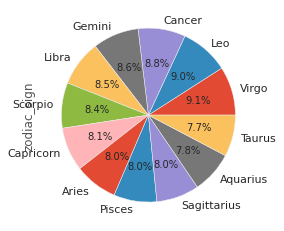

In [11]:
zsign.plot.pie(autopct="%.1f%%")
plt.show()

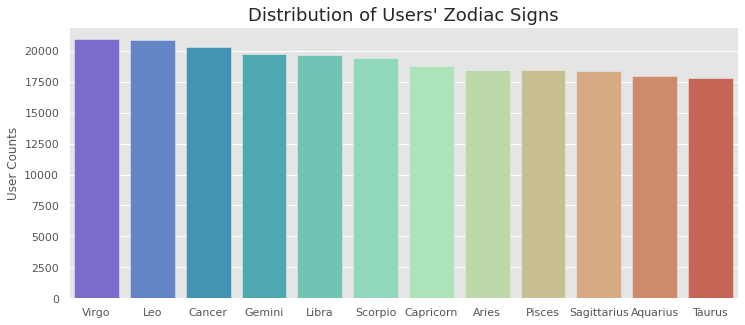

In [12]:
f, ax = plt.subplots(figsize=(12, 5))
ax = sns.barplot(y=zsign, x=zsign.index, palette="rainbow", saturation=0.5)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("User Counts", fontsize=12)
ax.set_title("Distribution of Users' Zodiac Signs", fontsize=18)
plt.show()

Our users' zodiac signs are distributed evenly. The ranks are correlated with the US population distribution to some degree, but some zodiac signs, like Leo with low population, are big fans of N26.

## 3 Exploratory Data Analysis
### 3.1 Spending 
### 3.1.1 Spending Overview

After checking with the boxplot with outliers, we found there are many outliers that we can not tell what is the general spending behavior from there. 
Also, by sorting the spending values and checking some of the users who have the top spend, we found that those users usually have few transactions with huge amounts of money, then become lapse MAU or close their account. 
Therefore, we decide to exclude the outliers and plot the boxplot.

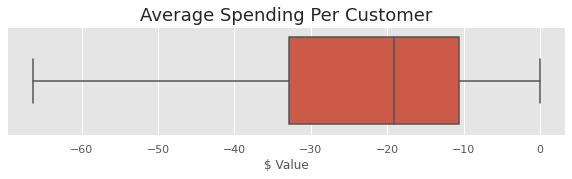

In [13]:
# avg spend per user per txn exclude outlier
f, ax = plt.subplots(figsize=(10, 2))
sns.boxplot(spending_agg["avg"], showfliers=False)
ax.set_title("Average Spending Per Customer", fontsize=18)
ax.set_xlabel("$ Value", fontsize=12)
plt.show()

Average spending per customer is from 10 to 35 dollors. Except the outliers. 

### 3.1.2 Transaction Frequency and Zodiac Sign

In [14]:
# standardize the datetime
spending["year_month"] = pd.to_datetime(spending["year_month"])

Since N26 officially launches in the US at the end of 2019 August, and by checking the overall trend, we found that we do not have many samples at the beginning which causes the large variance. Like we excluded the outliers for boxplot, we decided to exclude the data before October. 

In [15]:
spending = spending[spending.year_month >= "2019-10-01"]

In [16]:
txn_mean = (
    spending[["user_id", "zodiac_sign", "year_month", "txn_cnt"]]
    .groupby(["zodiac_sign", "year_month"])
    .agg("mean")
)

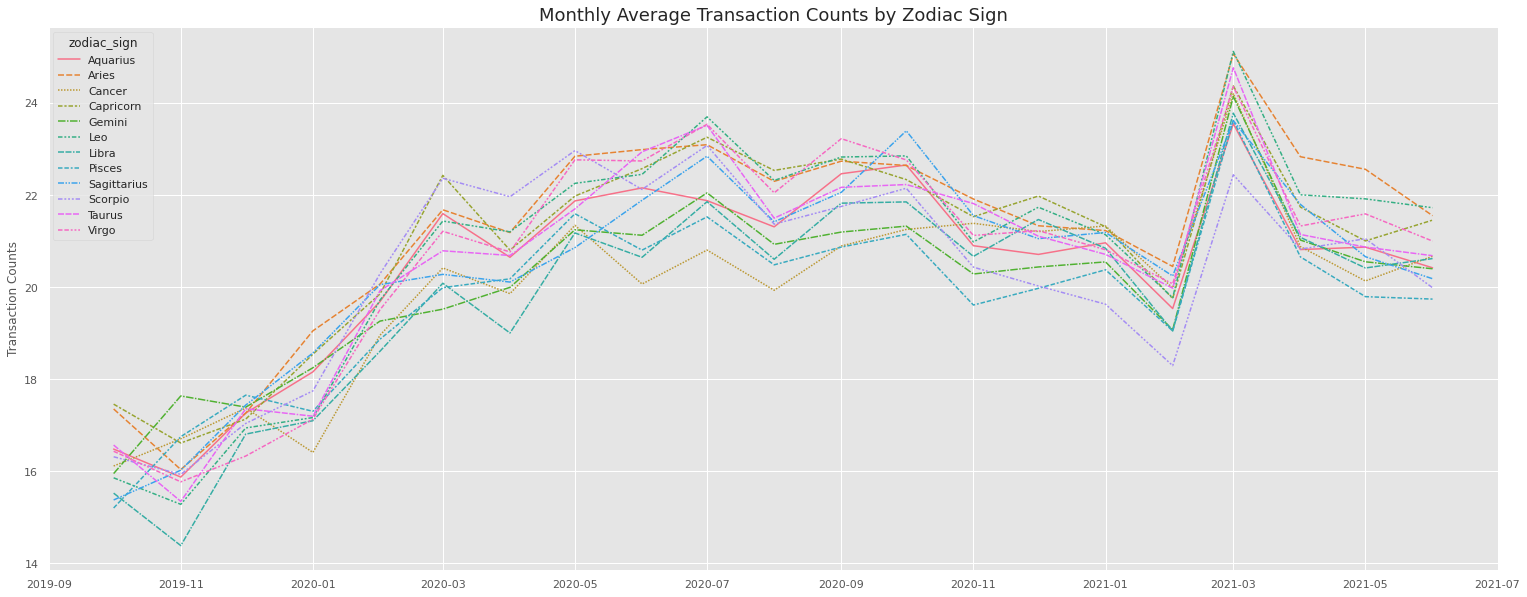

In [17]:
fig, ax = plt.subplots(figsize=(26, 10))
ax = sns.lineplot(
    data=txn_mean, x="year_month", y="txn_cnt", hue="zodiac_sign", style="zodiac_sign"
)

ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Transaction Counts", fontsize=12)
ax.set_title("Monthly Average Transaction Counts by Zodiac Sign", fontsize=18)

plt.show()

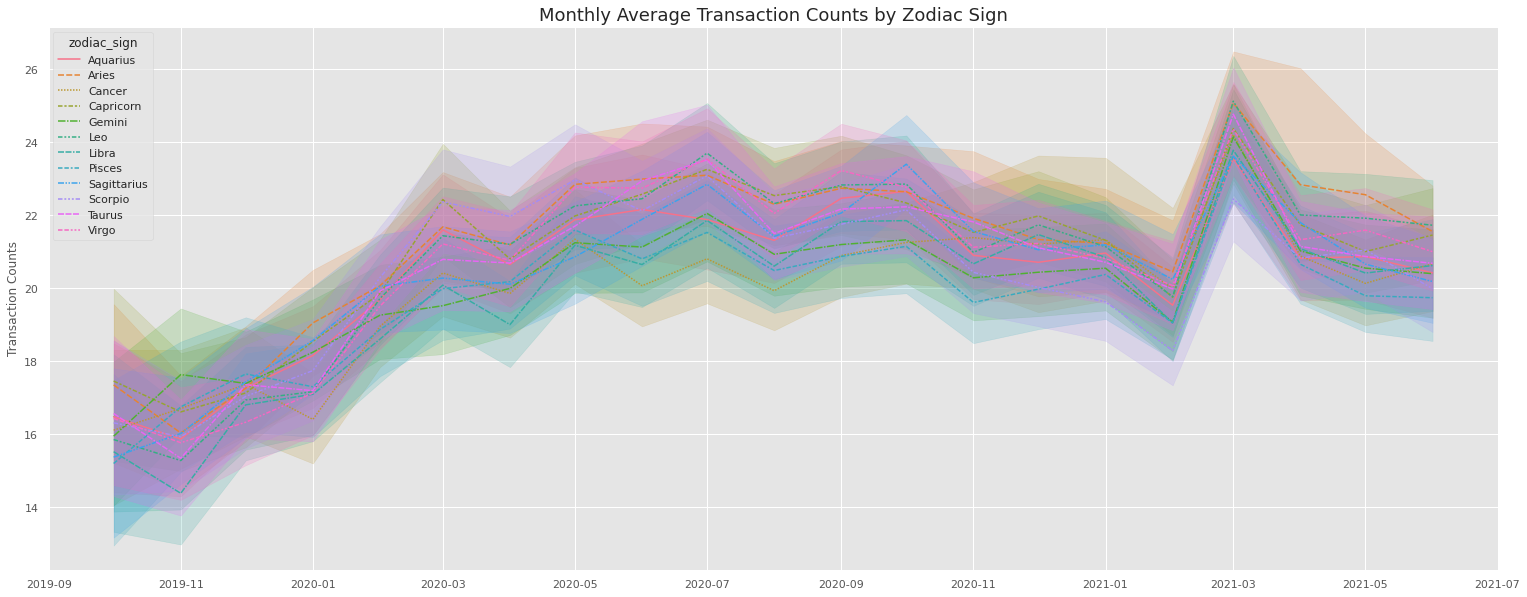

In [18]:
fig, ax = plt.subplots(figsize=(26, 10))
ax = sns.lineplot(
    data=spending, x="year_month", y="txn_cnt", hue="zodiac_sign", style="zodiac_sign"
)

ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Transaction Counts", fontsize=12)
ax.set_title("Monthly Average Transaction Counts by Zodiac Sign", fontsize=18)

plt.show()

Combine the above two charts together, we can see that 
- Average transaction counts were slowly increasing till the middle of 2020, and slightly decreased since the summer of 2020, we saw a boost in 2021 spring and went down again recently
- Scorpios made more transactions during the pandemic than other periods
- Cancers, usually do not make many transactions, made even less transactions during the pandemic

In [19]:
txn_mean.reset_index(inplace=True)
txn_mean = txn_mean[["zodiac_sign", "txn_cnt"]].groupby(["zodiac_sign"]).agg("mean")

In [20]:
txn_mean.sort_values("txn_cnt", ascending=False, inplace=True)
txn_mean.reset_index(inplace=True)

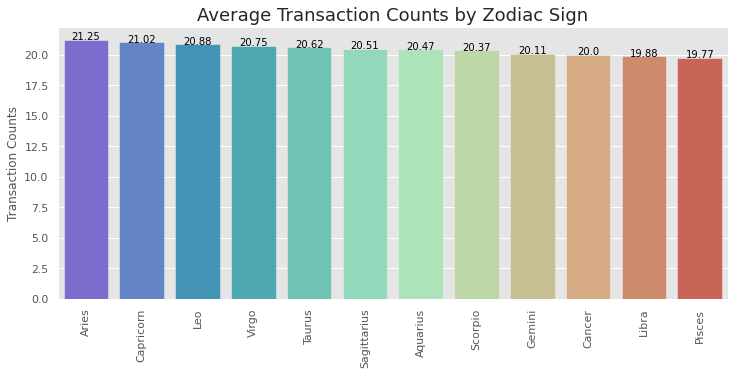

In [21]:
f, ax = plt.subplots(figsize=(12, 5))
ax = sns.barplot(
    y=txn_mean.txn_cnt, x=txn_mean.zodiac_sign, palette="rainbow", saturation=0.5
)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Transaction Counts", fontsize=12)
ax.set_title("Average Transaction Counts by Zodiac Sign", fontsize=18)

for index, row in txn_mean.iterrows():
    ax.text(row.name, row.txn_cnt, round(row.txn_cnt, 2), color="black", ha="center")

plt.xticks(rotation=90)
plt.show()

Exclude the effect of the overall zoidac signs population, we can see the top transaction counts zodiac signs are Aries, Capricorn, Leo, Virgo. Cancers, Libras, Pisceans make the least trancations, which comply with our trend graph too.

### 3.1.3 Average Spending and Zodiac Sign

In [22]:
spending_mean = (
    spending[["user_id", "zodiac_sign", "year_month", "avg"]]
    .groupby(["zodiac_sign", "year_month"])
    .agg("mean")
)

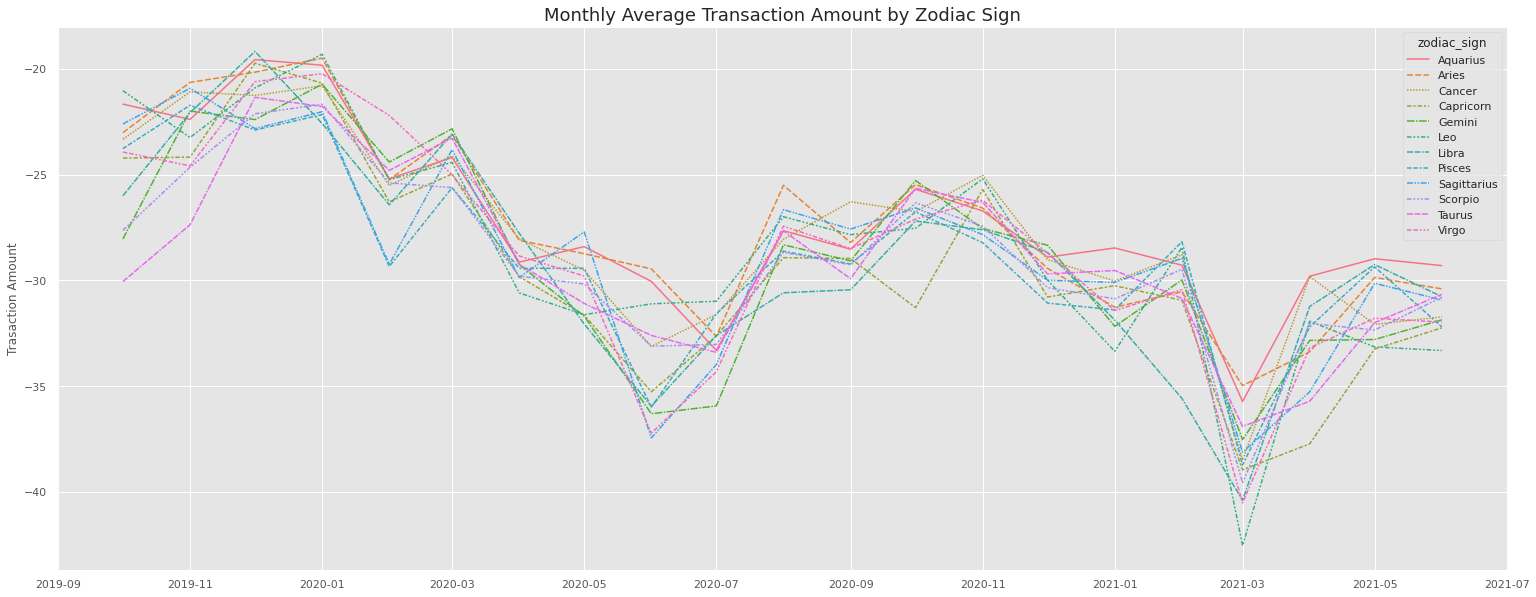

In [23]:
fig, ax = plt.subplots(figsize=(26, 10))
ax = sns.lineplot(
    data=spending_mean, x="year_month", y="avg", hue="zodiac_sign", style="zodiac_sign"
)

ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Trasaction Amount", fontsize=12)
ax.set_title("Monthly Average Transaction Amount by Zodiac Sign", fontsize=18)

plt.show()

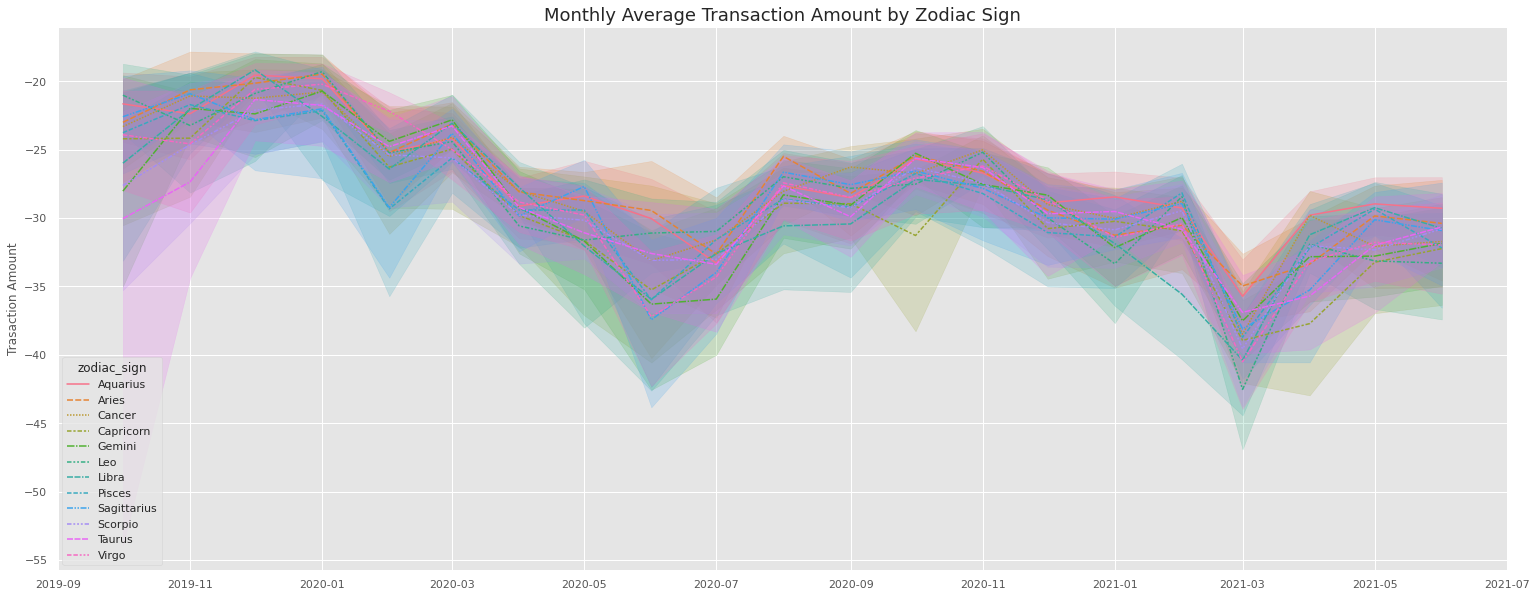

In [24]:
fig, ax = plt.subplots(figsize=(26, 10))
ax = sns.lineplot(
    data=spending, x="year_month", y="avg", hue="zodiac_sign", style="zodiac_sign"
)

ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Trasaction Amount", fontsize=12)
ax.set_title("Monthly Average Transaction Amount by Zodiac Sign", fontsize=18)

plt.show()

When we exclude the data before October 2019, we can tell:
- Purple group - Scorpios, Taurus and Aquarians spend more at the beginning than after
- Blue and green group - Sagittarius, Geminis, Leos spend more than purple group
- Yellow group which has the most transactions does not spend much money in each transaction
- Seasonality is not obvious for both transactions counts and spending amount


In [25]:
# merge with zodiac signs
spending_agg_z = pd.merge(left=uz, right=spending_agg, how="inner", on=["user_id"])

In [26]:
s_agg_z = spending_agg_z[["zodiac_sign", "avg"]].groupby(["zodiac_sign"]).agg("mean")

In [27]:
s_agg_z = abs(s_agg_z)
s_agg_z.sort_values("avg", ascending=False, inplace=True)
s_agg_z.reset_index(inplace=True)

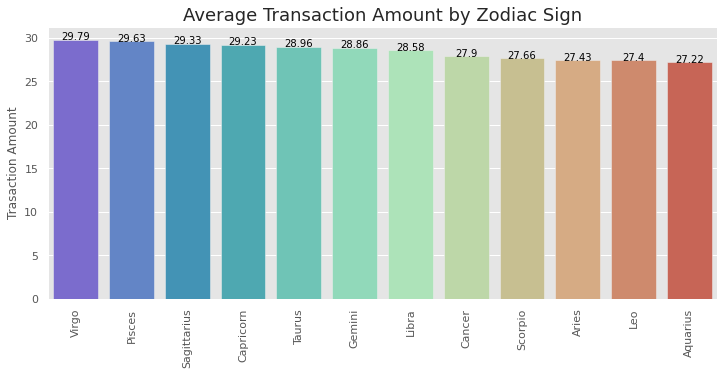

In [28]:
f, ax = plt.subplots(figsize=(12, 5))
ax = sns.barplot(
    y=s_agg_z.avg, x=s_agg_z.zodiac_sign, palette="rainbow", saturation=0.5
)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Trasaction Amount", fontsize=12)
ax.set_title("Average Transaction Amount by Zodiac Sign", fontsize=18)

for index, row in s_agg_z.iterrows():
    ax.text(row.name, row.avg, round(row.avg, 2), color="black", ha="center")

plt.xticks(rotation=90)
plt.show()

- Aries and Leos make more transactions while their transaction amounts are small
- Pisceans and Geminis make less transactions but amount per each transaction is higher than most of the others

In [29]:
avg_mon_s = pd.merge(left=s_agg_z, right=txn_mean, how="inner", on=["zodiac_sign"])

In [30]:
avg_mon_s["average_monthly_spend"] = avg_mon_s["avg"] * avg_mon_s["txn_cnt"]

In [31]:
avg_mon_s.sort_values("average_monthly_spend", ascending=False, inplace=True)
avg_mon_s.reset_index(inplace=True)

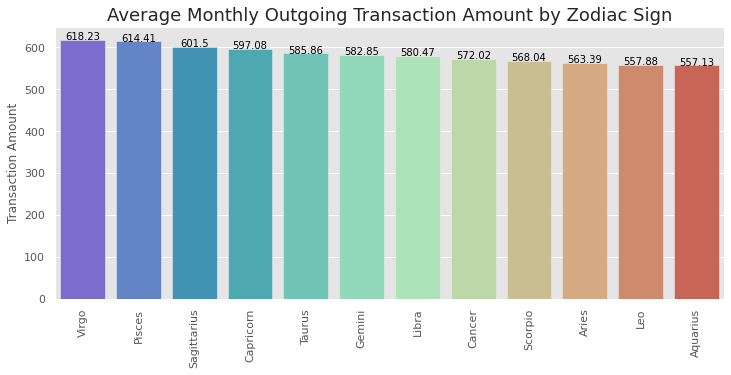

In [32]:
f, ax = plt.subplots(figsize=(12, 5))
ax = sns.barplot(
    y=avg_mon_s.average_monthly_spend,
    x=s_agg_z.zodiac_sign,
    palette="rainbow",
    saturation=0.5,
)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Transaction Amount", fontsize=12)
ax.set_title("Average Monthly Outgoing Transaction Amount by Zodiac Sign", fontsize=18)

for index, row in avg_mon_s.iterrows():
    ax.text(
        row.name,
        row.average_monthly_spend,
        round(row.average_monthly_spend, 2),
        color="black",
        ha="center",
    )

plt.xticks(rotation=90)
plt.show()

- Transactions counts are similar among different zodiac signs
- Virgos spend the most both per transaction and per month
- Aquarians spend the least both per transaction and per month

### 3.2 Earning 

In [33]:
# standardize datetime
earning["month_year"] = pd.to_datetime(earning["date"]).dt.to_period("M")
earning = earning[earning.month_year >= "2019-10"]

In [34]:
ez = pd.merge(left=uz, right=earning, how="inner", on=["user_id"])

In [35]:
ez["month_year"] = ez["month_year"].astype(str)

In [36]:
e_mean = (
    ez[["user_id", "zodiac_sign", "month_year", "direct_deposit_amount"]]
    .groupby(["zodiac_sign", "month_year"])
    .agg("mean")
)

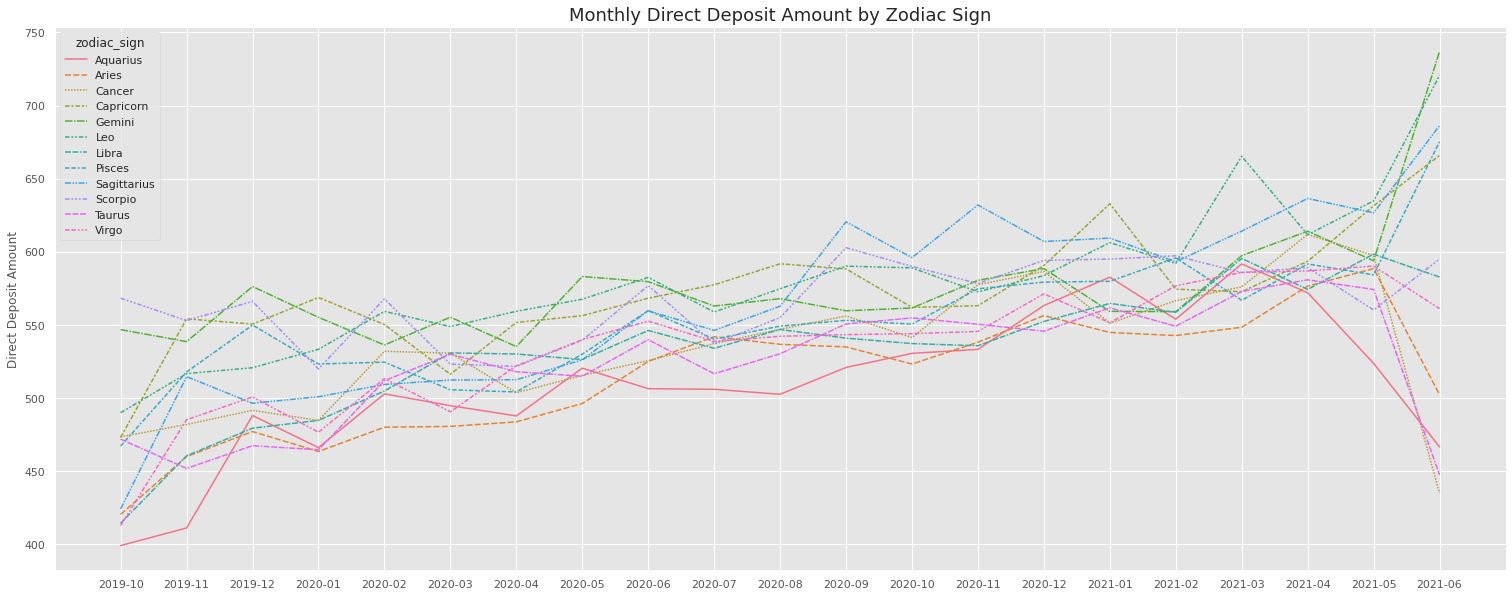

In [37]:
fig, ax = plt.subplots(figsize=(26, 10))
ax = sns.lineplot(
    data=e_mean,
    x="month_year",
    y="direct_deposit_amount",
    hue="zodiac_sign",
    style="zodiac_sign",
)

ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Direct Deposit Amount", fontsize=12)
ax.set_title("Monthly Direct Deposit Amount by Zodiac Sign", fontsize=18)

plt.show()

At the beginning, Pisceans, Scorpios and Aquarians and Libras earned more than average, other users were lower than the average. Since data before 2019 October have many outliers. I exclude the data before 2019 October to have a better view of the chart. 

We can tell the overall check amount is slightly increasing overtime. Leo is always on a high level. We can also move to the next chart to have simple view of the average paycheck per each zodiac sign.

In [38]:
# rpz = rp[['zodiac_sign', 'multiplier']].groupby(['zodiac_sign']).agg('mean')
monthly_earn_avg = (
    ez[["zodiac_sign", "direct_deposit_amount"]].groupby(["zodiac_sign"]).agg("mean")
)
monthly_earn_avg.sort_values("direct_deposit_amount", ascending=False, inplace=True)
monthly_earn_avg.reset_index(inplace=True)

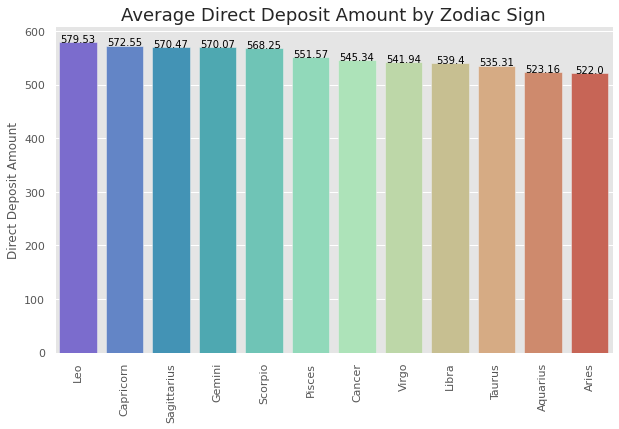

In [39]:
f, ax = plt.subplots(figsize=(10, 6))
x = monthly_earn_avg.zodiac_sign
y = monthly_earn_avg.direct_deposit_amount
ax = sns.barplot(x, y, palette="rainbow", saturation=0.5)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Direct Deposit Amount", fontsize=12)
ax.set_title("Average Direct Deposit Amount by Zodiac Sign", fontsize=18)

for index, row in monthly_earn_avg.iterrows():
    ax.text(
        row.name,
        row.direct_deposit_amount,
        round(row.direct_deposit_amount, 2),
        color="black",
        ha="center",
    )

plt.xticks(rotation=90)
plt.show()

Average amount of direct deposits transaction is slightly increasing overtime
Overall, Leos, Capricorns, Geminis and Sagittarius are on a high level while Aries, Aquarians and Taurus are on a low level

### 3.3 Savings 

### 3.3.1 Account Balance

In [40]:
# standardize datetime
saving["year_month"] = pd.to_datetime(saving["year_month"])

In [41]:
# to have a more valid mean value, we exclude the outlier data to plot
savingexo = saving[saving.year_month >= "2019-10-01"]
# savingexo = savingexo[savingexo.year_month < '2021-07']

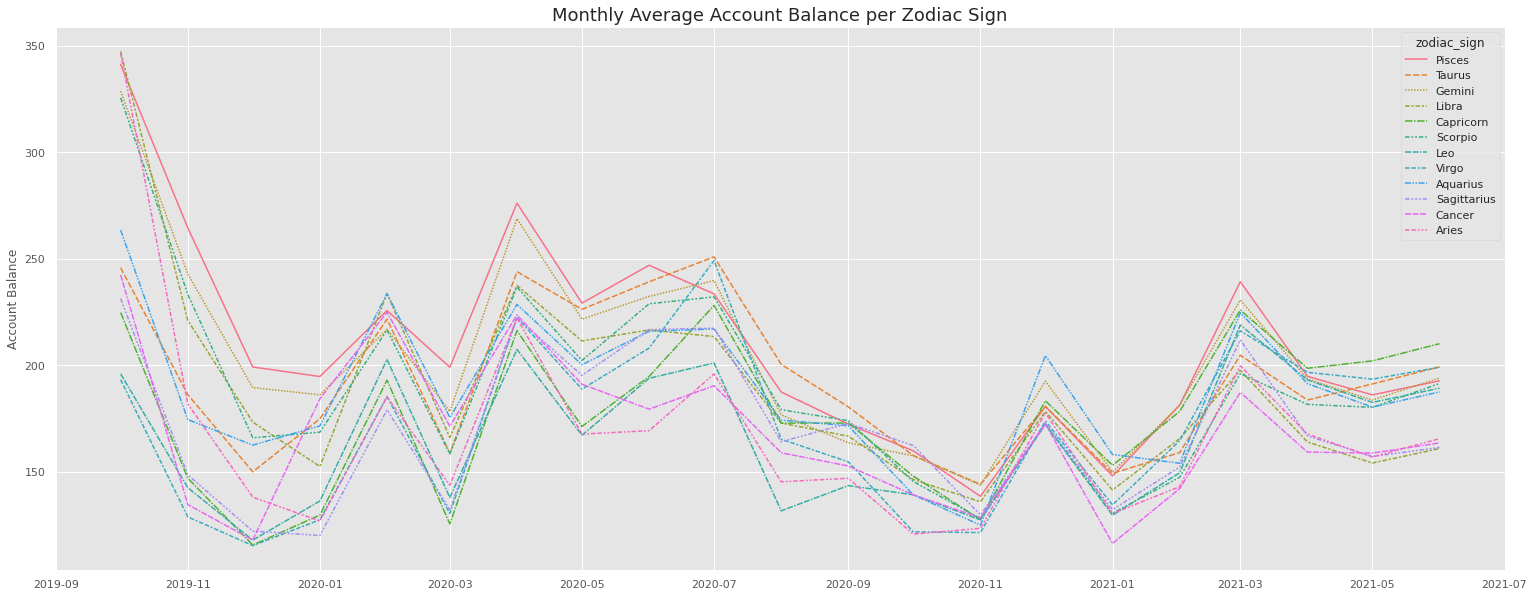

In [42]:
fig, ax = plt.subplots(figsize=(26, 10))
ax = sns.lineplot(
    data=savingexo,
    x="year_month",
    y="avg_agg_user_balance",
    hue="zodiac_sign",
    style="zodiac_sign",
)

ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Account Balance", fontsize=12)
ax.set_title("Monthly Average Account Balance per Zodiac Sign", fontsize=18)

plt.show()

- Account balance is not increasing
- Pisceans, Geminis and Taurus save the most, while Cancers and Leos have low account balance overtime

### 3.3.2 Saving Cohort Analysis


In [43]:
cohorts

,ft_funding,zodiac_sign,balance_month,ending_balance
0,2019-10,Cancer,2019-11,190.00
1,2019-10,Cancer,2019-12,190.00
2,2019-10,Cancer,2020-01,190.00
3,2019-10,Cancer,2020-02,190.00
4,2019-10,Cancer,2020-03,190.00
...,...,...,...,...
853540,2021-06,Aquarius,2021-06,134.21
853541,2021-06,Gemini,2021-06,209.84
853542,2021-06,Leo,2021-06,1.00
853543,2021-06,Gemini,2021-06,4.75


In [44]:
# to have a cleaner view of monthly savings per each zodiac signs
groupedz = cohorts.groupby(["zodiac_sign", "balance_month"])
cohortsz = groupedz.agg({"ending_balance": pd.Series.mean})
cohortsz.rename(columns={"ending_balance": "avg_balance"}, inplace=True)

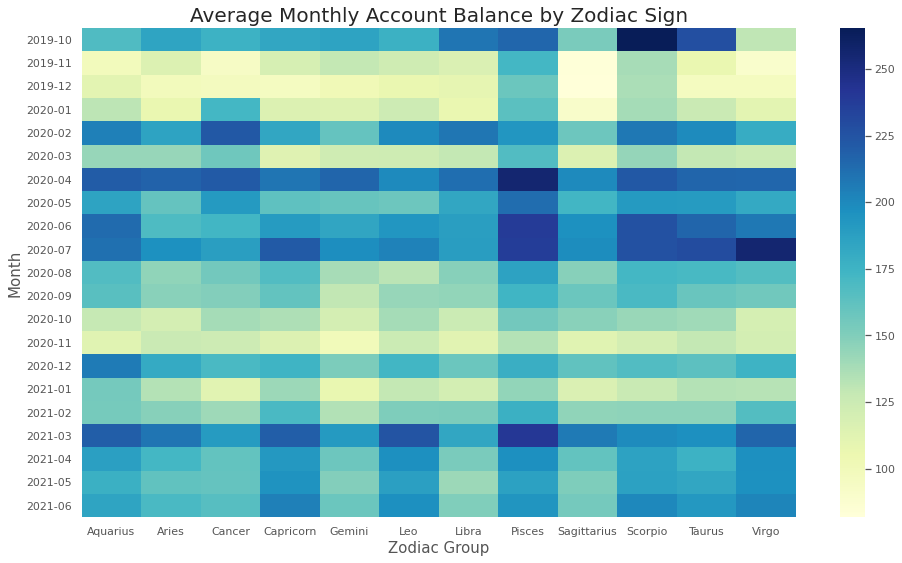

In [45]:
cohortsz.reset_index(inplace=True)
cohortsz.set_index(["zodiac_sign", "balance_month"], inplace=True)

avg_balance_z = cohortsz["avg_balance"].unstack(0)
plt.figure(figsize=(16, 9))
ax = sns.heatmap(avg_balance_z, annot=False, cmap="YlGnBu")

ax.set_ylabel("Month", fontsize=15)
ax.set_xlabel("Zodiac Group", fontsize=15)

ax.set_title("Average Monthly Account Balance by Zodiac Sign", fontsize=20)
plt.show()

- N26 users started to save more when the pandemic was getting worse
- Pisceans have the higher savings overall
- Aquarians, Capricorns, Leos, Pisceans, and Virgos saved more than others recently

In [46]:
grouped = cohorts.groupby(["ft_funding", "balance_month"])

In [47]:
cohort = grouped.agg({"ending_balance": pd.Series.mean})
cohort.rename(columns={"ending_balance": "avg_balance"}, inplace=True)

In [48]:
cohort.reset_index(inplace=True)
cohort.set_index(["ft_funding", "balance_month"], inplace=True)

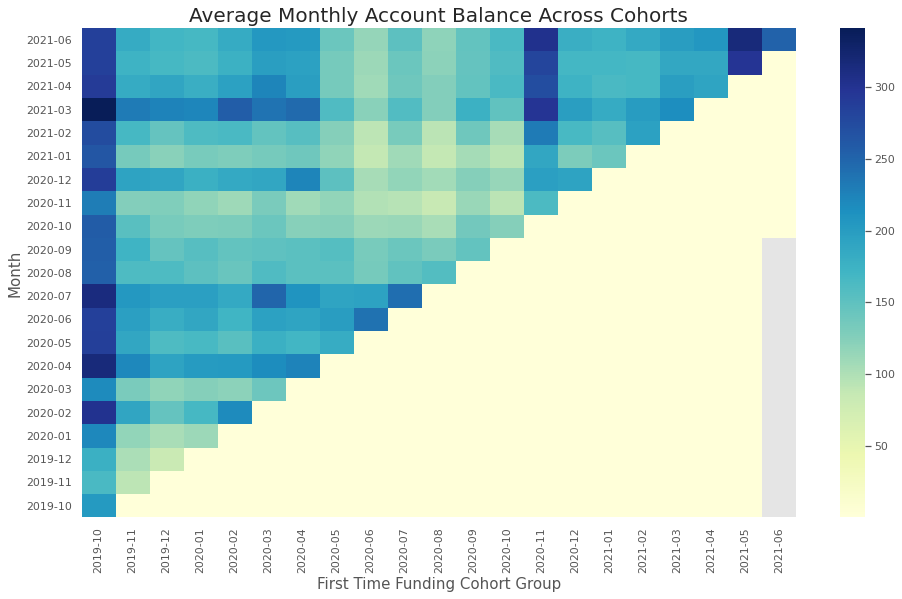

In [49]:
cohort.reset_index(inplace=True)
cohort.set_index(["ft_funding", "balance_month"], inplace=True)

avg_balance = cohort["avg_balance"].unstack(0)
plt.figure(figsize=(16, 9))
ax = sns.heatmap(avg_balance, annot=False, cmap="YlGnBu")

ax.set_ylabel("Month", fontsize=15)
ax.set_xlabel("First Time Funding Cohort Group", fontsize=15)
ax.invert_yaxis()

ax.set_title("Average Monthly Account Balance Across Cohorts", fontsize=20)
plt.show()

- This matches our line chart above, savings are not increasing over time
- Users created in the 2020 summer do not have a good amount of savings
- Overall average savings dropped in 2020 fall, and gradually goes back
- Users created in the 2020 summer do not have a good amount of savings
- Overall average savings dropped in 2020 fall, and gradually went back up recently 


### 3.3.4 Average Savings by Zodiac Sign

In [50]:
savingm = (
    savingexo[["zodiac_sign", "avg_agg_user_balance"]]
    .groupby(["zodiac_sign"])
    .agg("mean")
)

In [51]:
savingm.sort_values("avg_agg_user_balance", ascending=False, inplace=True)
savingm.reset_index(inplace=True)

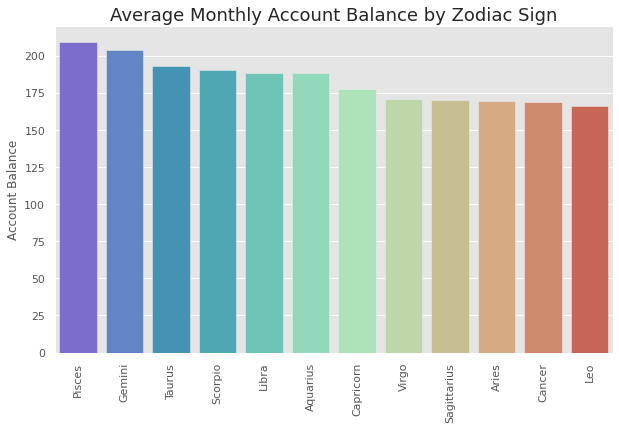

In [52]:
f, ax = plt.subplots(figsize=(10, 6))
x = savingm.zodiac_sign
y = savingm.avg_agg_user_balance
ax = sns.barplot(x, y, palette="rainbow", saturation=0.5)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Account Balance", fontsize=12)
ax.set_title("Average Monthly Account Balance by Zodiac Sign", fontsize=18)

# for index, row in savingm.iterrows():
#     ax.text(row.name,row.s, round(row.s,2), color='black', ha="center")

plt.xticks(rotation=90)
plt.show()

Pisceans saved the most, followed by are Gemini, Taurus, Libra, and Scorpio. Only Pisceans and Geminis have the amount over $200. Aries, Cancer and Leo do not save a lot of money.

### 3.3.3 Round up and Multiplier

In [53]:
# since roundup is a saving function, so here is analysis to compare the results with their total account balance
rp.sort_values("multiplier", ascending=True)

,id,user_id,multiplier
5076,c4b24c94-0ca9-44f0-b442-f0b6dd14ccc5,1f3c5adf-0a81-4eab-9e5c-517a8a97389f,1
8317,afc8e1e9-84ea-4e35-9e13-c54913e080c8,c10237c3-04bd-4488-a309-5c875d0acc70,1
3933,a3544471-a7df-4086-9989-c9f902ea5917,350401a4-76ad-4403-b543-e1465cc2cdb5,1
3928,a2e1cbc3-93a7-4818-a5ed-bb3e1f7526fc,81070d84-f052-4ff9-9234-517e7583ae14,1
3927,a283deda-6a08-47de-a106-b4c6fe9e7e00,befeb489-2f58-4615-8a2d-a6bcc6d8cb66,1
...,...,...,...
8098,8275347b-0457-4968-af6d-15197b70b905,ef794e58-c38e-4e1e-bc2f-f2d2d42ddce2,5
4379,20d4caf1-dcd9-40c6-bf12-95f95210bfb3,846b6a87-66d4-4c39-82d8-3d0e97ac12d6,5
8101,82b45b6f-a77b-45d2-8cf3-966edb4ef86d,414d4779-6313-4576-9920-6568d4dd9ade,5
8103,82f803b9-7adf-4009-8f81-e34ce26dbc11,11d006e7-2e8e-48f5-a927-68184dac2161,5


The SQL query for roundup data doesn't have time frame, since roundup launched in 2021. 

In [54]:
# merge with open accounts
rp = pd.merge(left=uz, right=rp, how="inner", on=["user_id"])

In [55]:
rpz = rp[["zodiac_sign", "multiplier"]].groupby(["zodiac_sign"]).agg("mean")

In [56]:
rpz.sort_values("multiplier", ascending=False, inplace=True)

In [57]:
rpz.reset_index(inplace=True)

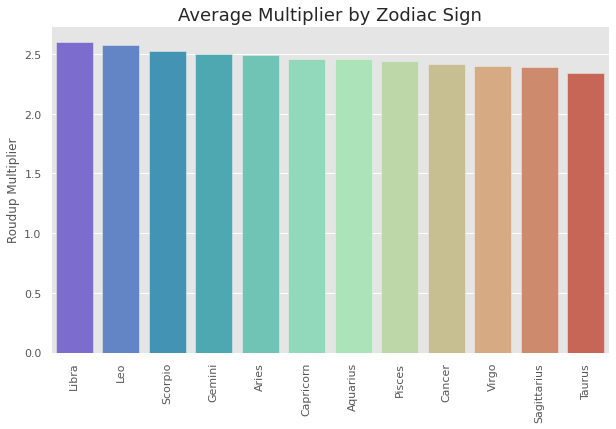

In [58]:
f, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(y=rpz.multiplier, x=rpz.zodiac_sign, palette="rainbow", saturation=0.5)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Roudup Multiplier", fontsize=12)
ax.set_title("Average Multiplier by Zodiac Sign", fontsize=18)
plt.xticks(rotation=90)
plt.show()

Libra, Leo, Scorpio and Gemini are those who like to save money,using round up. Since this doesn't match the saving results, we did a Hypothesis test to see if there are differences between those multipliers. 

In [59]:
# Whether a zodiac's choices are different from the rest of the population
# hypothese test, check the distribution to decide the test method
lib = rp[rp["zodiac_sign"] == "Libra"]["multiplier"]
ari = rp[rp["zodiac_sign"] == "Aries"]["multiplier"]

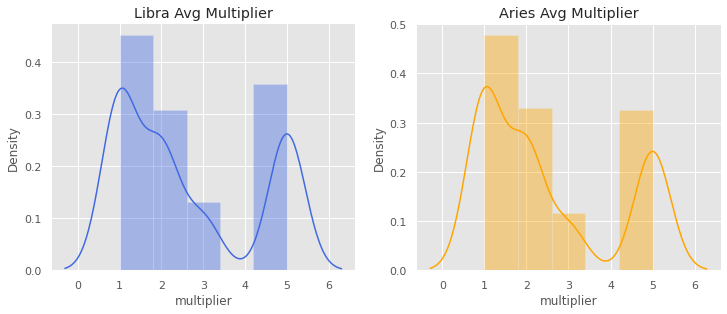

In [60]:
# plt to see if they comply to normal distribution
fig = plt.subplots(figsize=(12, 10))

ax1 = plt.subplot(221)
sns.distplot(lib, color="royalblue", ax=ax1)
ax1.set_title("Libra Avg Multiplier")

ax2 = plt.subplot(222)
sns.distplot(ari, color="orange", ax=ax2)
ax2.set_title("Aries Avg Multiplier")

plt.show()

In [61]:
# for loop to compare the 12 zodiac signs
sign_list = []
test_result = []
for sign in rp["zodiac_sign"].unique():
    test = st.mannwhitneyu(
        rp[rp["zodiac_sign"] == sign]["multiplier"],
        rp[rp["zodiac_sign"] != sign]["multiplier"],
        use_continuity=True,
        alternative="two-sided",
    )
    sign_list.append(sign)
    test_result.append(test.pvalue)
pd.DataFrame({"zodiac_sign": sign_list, "pvalue": test_result})

,zodiac_sign,pvalue
0,Aquarius,0.915217
1,Capricorn,0.942893
2,Libra,0.030419
3,Leo,0.061188
4,Sagittarius,0.111060
5,Taurus,0.039015
6,Pisces,0.741993
7,Scorpio,0.098237
8,Virgo,0.171618
9,Aries,0.775474


Only Libra, and Taurus's p value is smaller than 0.05, reject the null hypothesis, which means Libra multiplier is significantly higher than others and Taurus is significantly smaller than the population. For others, their pvalue are higher than alpha, which means there is no significant difference between them and the population.
We can interpret these higher multipliers as a desire to save. For those who activate round-up, only Geminis, Libras, and Scorpios actually saved more than others.

### 3.4 Referring  

In [62]:
# which zodiac Sign likes to share, we are using the rf table, including all the user data
# join with zodiac table
rfz = pd.merge(left=uz, right=rf, how="inner", on=["user_id"])

In [63]:
rfz = rfz[["zodiac_sign", "cnt"]].groupby(["zodiac_sign"]).agg("mean")

In [64]:
rfz.sort_values("cnt", ascending=False, inplace=True)

In [65]:
rfz.reset_index(inplace=True)

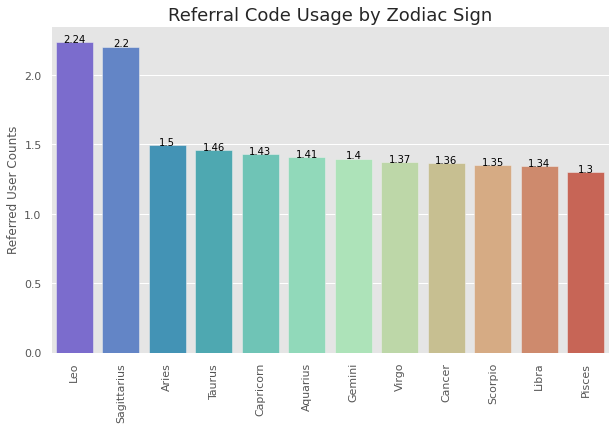

In [66]:
f, ax = plt.subplots(figsize=(10, 6))
x = rfz.zodiac_sign
y = rfz.cnt
ax = sns.barplot(x, y, palette="rainbow", saturation=0.5)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Referred User Counts", fontsize=12)
ax.set_title("Referral Code Usage by Zodiac Sign", fontsize=18)

for index, row in rfz.iterrows():
    ax.text(row.name, row.cnt, round(row.cnt, 2), color="black", ha="center")

plt.xticks(rotation=90)
plt.show()

- On average, Leos and Sagittarius successfully referred more than 2 new users 
- Leos are most willing to share N26 with others
- Sagittarians, Aries, Taurus and Capricorns also like to recommend the product to others
- Pisceans are least willing to refer